In this notebook, RNN estimator is used as a reference model.
This choice is leaded by the fact that :

<pre>
<li>NN model are non-linear models, then it is supposed to capture non-linear relations in between features </li>
<li>RNN model provides results more efficiently considering time criteria.</li>
</pre>

Multiple dataset are used in order to benchmark assumptions forged about model.  

GRU NN uses few parameters. 

    Then IBFGS may be used rather then SGD for descent algorithm.

In [46]:
%load_ext autoreload
%autoreload 2

[nltk_data] Downloading package stopwords to /home/bangui/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [47]:
import numpy as np
import time

import tensorflow as tf
import pandas as pd
import gensim

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline


import p8_util
import p8_util_config
import p9_util

import p5_util

extension='_part'

In [48]:
OUTPUT_DIR = './tmp/baseline'
OUTPUT_DIR_TB = './tmp'
is_tensorboard = False

#### Tensorboard processes are killed

In [49]:
# this will kill the processes for Tensorboard
#is_tensorboard = True
if is_tensorboard is True :
    !ps aux | grep tensorboard | awk '{print $2}' | xargs kill
# this will kill the processes for ngrok
if is_tensorboard is True :
    !ps aux | grep ngrok | awk '{print $2}' | xargs kill    

# <font color=blus>1. Loading BOW dataset</font>

In [90]:
import p9_util
X_train, X_test, y_train, y_test, keras_tokenizer = \
p9_util.load_or_dump_tokenized_corpus(dump=False, content_type='bow', extension='_part')

p5_util.object_load : fileName= ./data/keras_tokenizer_part.dump
p5_util.object_load : fileName= ./data/X_train_bow_part.dump
p5_util.object_load : fileName= ./data/y_train_bow_part.dump
p5_util.object_load : fileName= ./data/X_test_bow_part.dump
p5_util.object_load : fileName= ./data/y_test_bow_part.dump

X_train_encoded shape = (361241, 100)
X_test_encoded shape  = (177863, 100)
Y train shape= (361241,)
Y test shape= (177863,)
Vocabulary size= 128062


    Display an item from tokenized corpus

In [91]:
print(X_train.shape)
print(X_train.min(),X_train.mean(),X_train.max())
X_train[:,0].shape

(361241, 100)
0 1059.7935163782627 128061


(361241,)

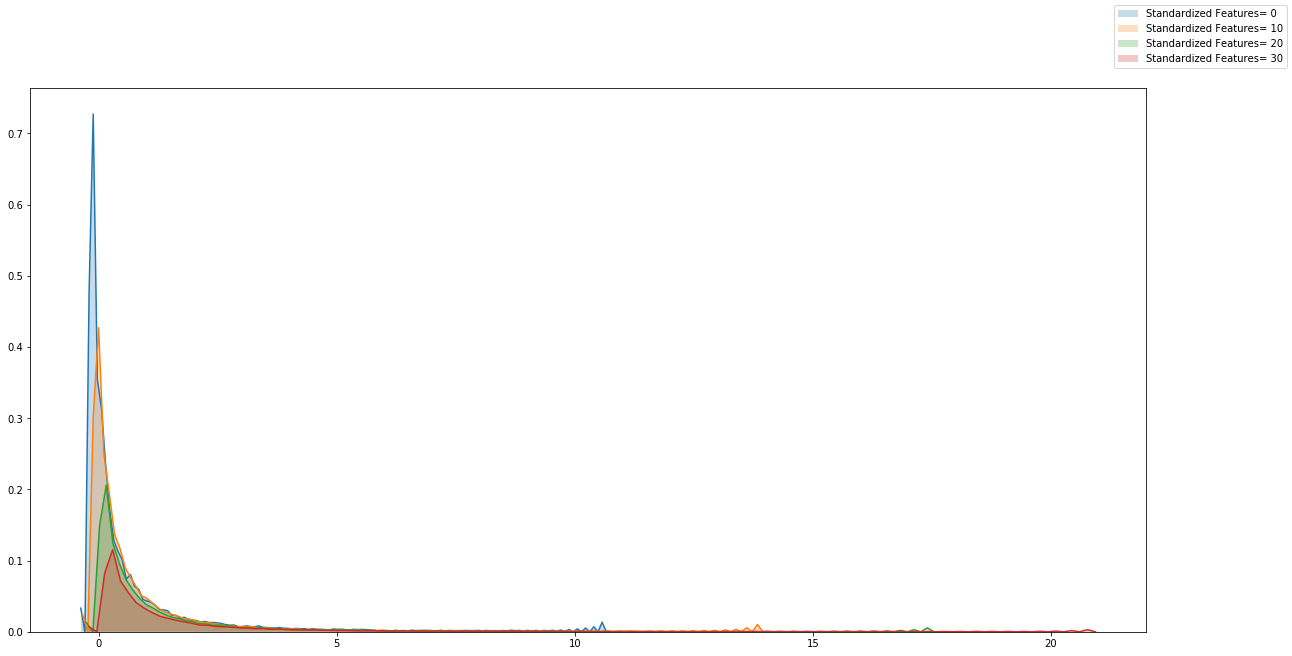

X_train min=-0.371 Mean=-0.0 Max=253.639


In [99]:
import matplotlib.pyplot as plt
import seaborn as sns
list_column=[0,10,20,30]
list_label = list()
fig = plt.figure(figsize=(20,10))
for column in list_column :
    _=sns.kdeplot(X_train[:,column], shade=True)
    list_label.append("Standardized Features= "+str(column))
fig.legend(labels=list_label)
plt.show()
print("Inputs: min={} Mean={} Max={}".format(round(X_train.min(),3),round(X_train.mean(),3),round(X_train.max(),3)))

    Features are standardized in order to be zero centered and reduced to a standard deviation to 1.
    Doing so, variability of a variable will reflect its importance.
    
    Scaling input in a such way lead that the more important inputs with a larger variance.
    
    For NN, standardizing inputs removes the problem of scale dependency of the initial weights.
    It also avoid saturation and increase learning performance while also avoiding learning process 
    to be stuck in a minima.


In [111]:
import p9_util
std_scaler, X_train, X_test = p9_util.data_scale(X_train, X_test, scaler_name='Standard')

[nltk_data] Downloading package stopwords to /home/bangui/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


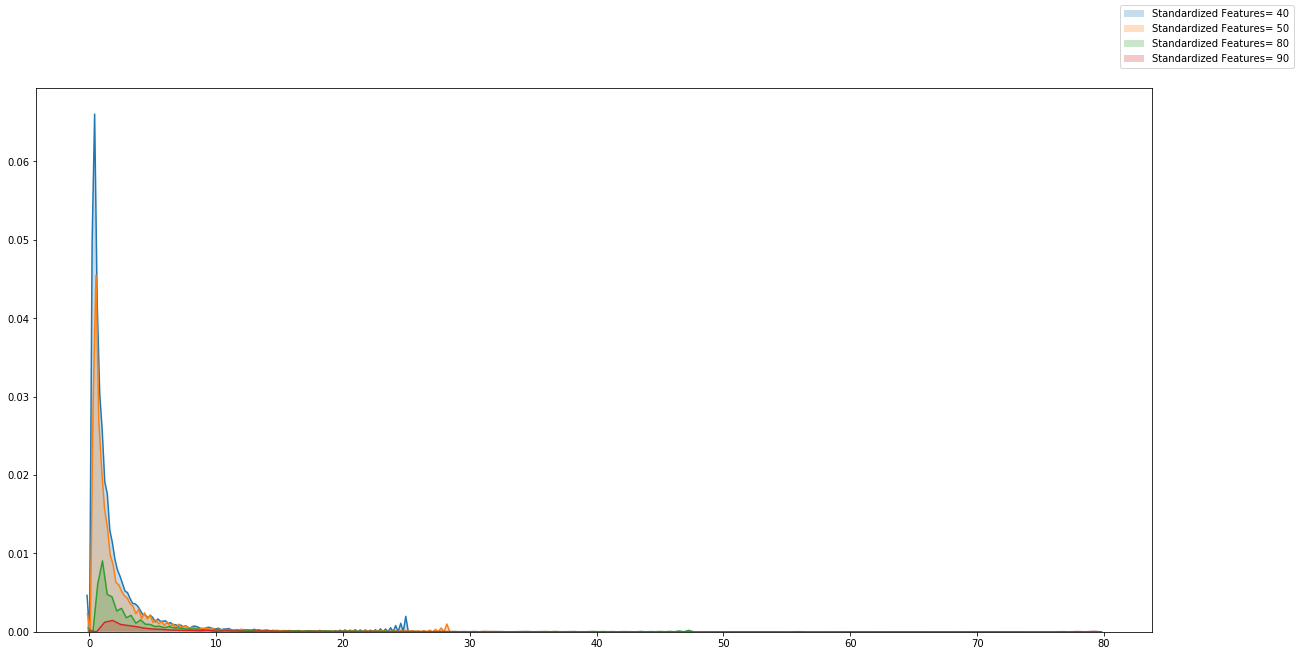

Inputs: min=-0.371 Mean=0.0 Max=253.639


In [112]:
import matplotlib.pyplot as plt
import seaborn as sns
list_column=[40,50,80,90]
list_label = list()
fig = plt.figure(figsize=(20,10))
for column in list_column :
    _=sns.kdeplot(X_train[:,column], shade=True)
    list_label.append("Standardized Features= "+str(column))
fig.legend(labels=list_label)
plt.show()
print("Inputs: min={} Mean={} Max={}".format(round(X_train.min(),3),round(X_train.mean(),3),round(X_train.max(),3)))

In [113]:
print("X_train standard deviation ...: {}".format("\n"+str(X_train.std(axis=0))))
print()
print("X_train mean .................: {}".format("\n"+str(X_train.mean(axis=0))))

X_train standard deviation ...: 
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1.]

X_train mean .................: 
[-1.88551285e-15 -2.54739298e-16 -7.82572297e-17 -5.76017663e-15
 -8.16303019e-15 -2.05112859e-17 -3.51963881e-15 -1.87278737e-14
  8.67164117e-15  2.28800705e-14  2.58155130e-14  8.71202341e-15
  1.03200495e-14 -8.98402853e-15 -1.72217553e-15 -2.12732498e-15
  2.99046183e-15 -1.70635605e-14  5.22991857e-14 -1.07521103e-14
 -8.36347215e-15 -2.74634167e-14  1.62086562e-14 -1.94391756e-14
 -2.85190859e-14 -4.57802687e-14 -4.77522139e-15 -6.42085616e-15
 -1.31109021e-14  4.37907226e-16 -2.95973874e-14 -1.34337490e-15
 -8.10430292e-16  1.23758703e-14 -7.16479918e-15 -1.41941084e-14
  9.39937577e-15 -1.07373905e-14 -2.830732

# <font color=blus>2. Modeling with RNN</font>

In [14]:
max_length = len(X_train[0])
batch_size = X_train.shape[0]//10

# This is the size of vector words.
embedding_dim = 100

vocab_size = len(keras_tokenizer.word_index) + 1
print("\nInput length= {}".format(max_length))
print("Vocabulary size= {}".format(vocab_size))
print("Batch size= {}".format(batch_size))
print("Embeddings dimension= {}".format(embedding_dim))
#print("Number of units per RNN cell= {}".format(cell_units))



Input length= 100
Vocabulary size= 128062
Batch size= 36124
Embeddings dimension= 100


## <font color=blus>2.1 Switch to a binary classification problem</font>

    Targets, that are coninues values from float type, are converted into classes of integers, such leading to a classification model.
    
    For doing that, y_train_encoded and y_test_encoded are transformed as array of integers, 
    ranging from 0 to 10, leading to 11 classes.

Target is splitted based 

`y_train_label` and `y_test_label` are arrays with number of columns as number of classes.

Classes are one-hot-encoded for each observation.

In [116]:
y_train.min(), y_train.max()

(0.0, 1.0)

`y_train` and `y_test` are vectors with float values ranging from `0.0` to `1.0`. 

Before to be converted as labels ranged to [0,10], `y_train` and `y_test` are scaled to `10`.

`decimal_count` is the value allowing to take into account the number of decimals when converting continuous values into classes.

As a result, `y_train_label` and `y_test_label` are `[N x Classes]` matrix issued from One-hot-encoding were position of 1 value in a column indicates the class value.



In [115]:
import p9_util
decimal_count=1
nb_classes, y_train_label = p9_util.y_cont_2_label(y_train*10, decimal_count=decimal_count)
_, y_test_label = p9_util.y_cont_2_label(y_test, decimal_count=decimal_count)

print("\nNumber of classes= {}".format(nb_classes))


Number of classes= 11


### <font color=blus>2.1.1 Building new target vector classes</font>

`y_train_label_vect` and `y_test_label_vect` are vectors issues from `[N x Classes]` matrix, where `N` is the 
number of samples and `Classes` the number of classes.

After this target conversion, unique column values are classes number, ranged from `0` to `10`.

In [117]:
import p9_util

y_train_label_vect = np.array([p9_util.get_label_from_row(y_train_label[row]) for row in range(0,len(y_train_label))])
y_test_label_vect  = np.array([p9_util.get_label_from_row(y_test_label[row])  for row in range(0,len(y_test_label))])

`Counter` class from `collection` package is used in order to compute occurencies fo each class in the data-model.

In [118]:
from collections import Counter

counter_y_train_label_vect = Counter(y_train_label_vect)
counter_y_test_label_vect  = Counter(y_test_label_vect)

print(counter_y_train_label_vect, counter_y_train_label_vect[0]+counter_y_train_label_vect[1])
print(counter_y_test_label_vect, counter_y_test_label_vect[0]+counter_y_test_label_vect[1])

Counter({0: 253411, 1: 32137, 2: 22260, 3: 12955, 4: 11372, 5: 9642, 6: 7585, 7: 5475, 8: 4449, 9: 1055, 10: 900}) 285548
Counter({0: 177365, 1: 498}) 177863


    Diagram below shows classes distribution for train (blue) and test (orange) dataset.

    Both diagrams shows same shape.

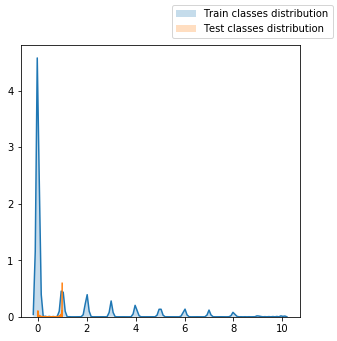

In [119]:
import matplotlib.pyplot as plt
import seaborn as sns

fig = plt.figure(figsize=(5,5))
_=sns.kdeplot(y_train_label_vect, shade=True)
_=sns.kdeplot(y_test_label_vect, shade=True)
fig.legend(labels=['Train classes distribution','Test classes distribution'])
plt.show()

### <font color=blus>2.1.2 conversion of targets values as binaries values</font>

`threshold` parameter is the value delimiting `0` class from `1` class.

`direction` parameter fixes the direction of test for threshold. 

When value is fixed to `1` then test direction is `value > threshold` and leads to class value `1`, class value `0` otherwise.

In [120]:
threshold = 0
direction = 1
y_train_label_vect_bin = p9_util.multivalue2_binary(y_train_label_vect, threshold, direction)
y_test_label_vect_bin = p9_util.multivalue2_binary(y_test_label_vect, threshold, direction)

In [121]:
from collections import Counter
counter_y_train_label_bin = Counter(y_train_label_vect_bin)
counter_y_test_label_bin  = Counter(y_test_label_vect_bin)

print(counter_y_train_label_bin, counter_y_train_label_bin[0]+counter_y_train_label_bin[1])
print(counter_y_test_label_bin, counter_y_test_label_bin[0]+counter_y_test_label_bin[1])

Counter({0: 253411, 1: 107830}) 361241
Counter({0: 177365, 1: 498}) 177863


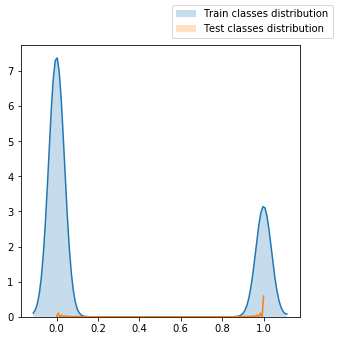

In [122]:
fig = plt.figure(figsize=(5,5))
_=sns.kdeplot(y_train_label_vect_bin, shade=True)
_=sns.kdeplot(y_test_label_vect_bin, shade=True)
fig.legend(labels=['Train classes distribution','Test classes distribution'])
plt.show()

### <font color=blus>2.1.3 Applying RNN model</font>

#### <font color='blus'>2.1.3.1 SGD optimizer</font>

For feeding RNN network :

`y_train_label_vect_bin` and `y_test_label_vect_bin` are converted into matrix where 
number of columns is the number of classes.

`y_train_label_vect_bin` and `y_test_label_vect_bin` have values in set `{0,1}`. No scale is applied.

`X_train` and `X_test` are reshaped.


In [123]:
decimal_count=0
nb_classes, y_train_label_bin = p9_util.y_cont_2_label(y_train_label_vect_bin, decimal_count=decimal_count)
_, y_test_label_bin = p9_util.y_cont_2_label(y_test_label_vect_bin*1, decimal_count=decimal_count)

print("\nNumber of classes= {}".format(nb_classes))

import p9_util

X_train_reshape = p9_util.keras_rnn_reshape(X_train)
X_test_reshape = p9_util.keras_rnn_reshape(X_test)

print(y_train_label_bin.shape)
print(y_test_label_bin.shape)



Number of classes= 2
(361241, 1, 100)
(177863, 1, 100)
(361241, 2)
(177863, 2)


    RNN hyper-parameters are fixed

In [124]:
lstm_out = 1
cell_units = 16
rnn_layers = 1

    Batch normalization is applied in between each RNN layer.

In [125]:
import p9_util

rnnCellType = 'GRU'
batch_size = X_train.shape[0]//10
max_length = X_train.shape[1]
model = p9_util.keras_rnn_build(rnnCellType, cell_units, max_length, isWordEmbedding=False\
                   , nbClasses=nb_classes, rnn_layers=rnn_layers, is_batch_normalized=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_9 (GRU)                  (None, 1, 16)             5616      
_________________________________________________________________
batch_normalization_9 (Batch (None, 1, 16)             64        
_________________________________________________________________
gru_10 (GRU)                 (None, 16)                1584      
_________________________________________________________________
batch_normalization_10 (Batc (None, 16)                64        
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 34        
Total params: 7,362
Trainable params: 7,298
Non-trainable params: 64
_________________________________________________________________
None


In [126]:
history = model.fit(X_train_reshape, y_train_label_bin, batch_size =batch_size, nb_epoch = 10
                    ,validation_data=(X_test_reshape,y_test_label_bin),  verbose = 1)

Train on 361241 samples, validate on 177863 samples
Epoch 1/10
361241/361241 [==============================] - 8s 21us/step - loss: 1.0249 - acc: 0.4435 - val_loss: 0.9235 - val_acc: 0.4605
Epoch 2/10
361241/361241 [==============================] - 1s 3us/step - loss: 0.9313 - acc: 0.4665 - val_loss: 0.8198 - val_acc: 0.6112
Epoch 3/10
361241/361241 [==============================] - 1s 3us/step - loss: 0.8502 - acc: 0.5606 - val_loss: 0.7407 - val_acc: 0.7022
Epoch 4/10
361241/361241 [==============================] - 1s 4us/step - loss: 0.7958 - acc: 0.5982 - val_loss: 0.6147 - val_acc: 0.7784
Epoch 5/10
361241/361241 [==============================] - 2s 5us/step - loss: 0.7567 - acc: 0.6155 - val_loss: 0.5848 - val_acc: 0.7966
Epoch 6/10
361241/361241 [==============================] - 1s 3us/step - loss: 0.7301 - acc: 0.6268 - val_loss: 0.5779 - val_acc: 0.8055
Epoch 7/10
361241/361241 [==============================] - 1s 3us/step - loss: 0.7123 - acc: 0.6349 - val_loss: 0.5665

In [3]:
import keras
import p5_util
core_name = "gru_"+str(rnn_layers)+"layers_"+str(cell_units)+'units_class_binary'

if False :
    model.save("./data/model_"+core_name+".h5")
    p5_util.object_dump(history, "history_"+core_name+".dump")
    p5_util.object_dump(max_length, "max_length_"+core_name+".dump")
    
else :
    model = keras.models.load_model("./data/model_"+core_name+".h5")
    history = p5_util.object_load("history_"+core_name+".dump")
    max_length = p5_util.object_load("max_length_"+core_name+".dump")

print("\nInput data length= {}".format(max_length))
model.summary()

W0806 11:15:48.337492 140106701928256 deprecation_wrapper.py:119] From /home/bangui/anaconda3/envs/python36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0806 11:15:48.348399 140106701928256 deprecation_wrapper.py:119] From /home/bangui/anaconda3/envs/python36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0806 11:15:48.350718 140106701928256 deprecation_wrapper.py:119] From /home/bangui/anaconda3/envs/python36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0806 11:15:48.541450 140106701928256 deprecation_wrapper.py:119] From /home/bangui/anaconda3/envs/python36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_

p5_util.object_load : fileName= history_gru_1layers_16units_class_binary.dump
p5_util.object_load : fileName= max_length_gru_1layers_16units_class_binary.dump

Input data length= 100
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 1, 16)             5616      
_________________________________________________________________
batch_normalization_1 (Batch (None, 1, 16)             64        
_________________________________________________________________
gru_2 (GRU)                  (None, 16)                1584      
_________________________________________________________________
batch_normalization_2 (Batch (None, 16)                64        
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 34        
Total params: 7,362
Trainable params: 7,298
Non-trainable params: 64
______________________

#### <font color=blus>Computation of classifications performances</font>

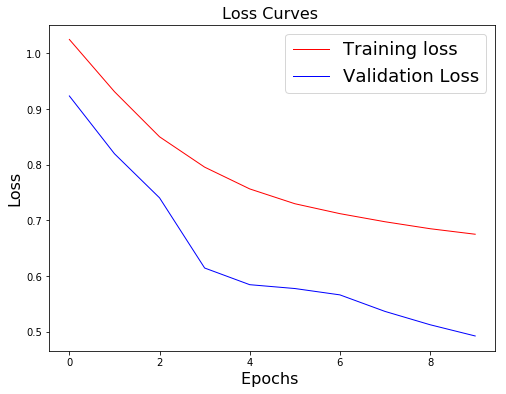

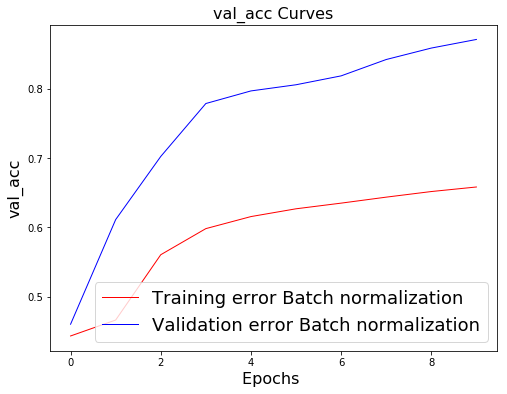

In [127]:
import p7_util

list_model_acc_value = p7_util.p7_plot_cnn_history(model, None, None, history=history, legend='Batch normalization')

177863/177863 [==============================] - 7s 41us/step
[0, 1]

Confusion matrix for all classes : 

[[154813  22552]
 [   445     53]]

Normalized confusion matrix
[[0.87284977 0.12715023]
 [0.8935743  0.1064257 ]]

TP rate = [0.        0.1064257 1.       ]
FP rate = [0.         0.12715023 1.        ]


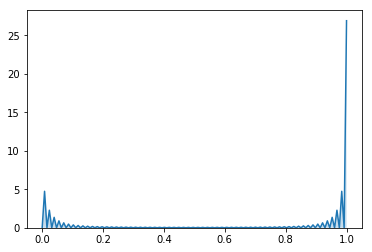

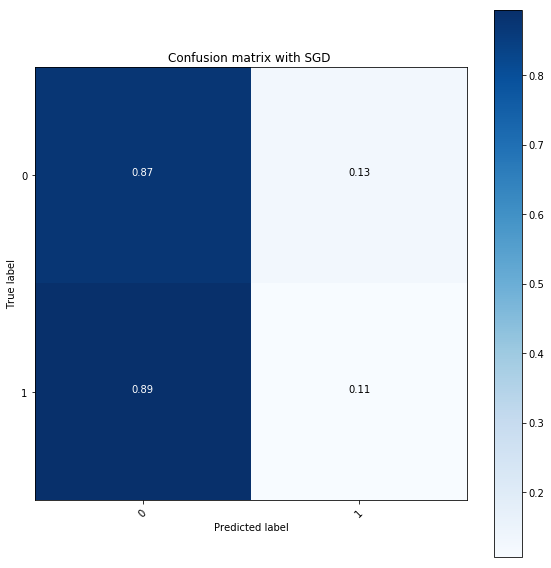

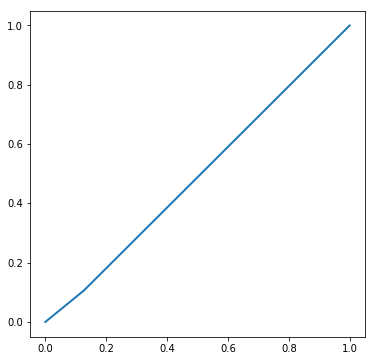

In [128]:
import p9_util
y_= p9_util.display_class_performance(model, X_test_reshape, y_test_label_bin, is_binary=True, y_pred=None)

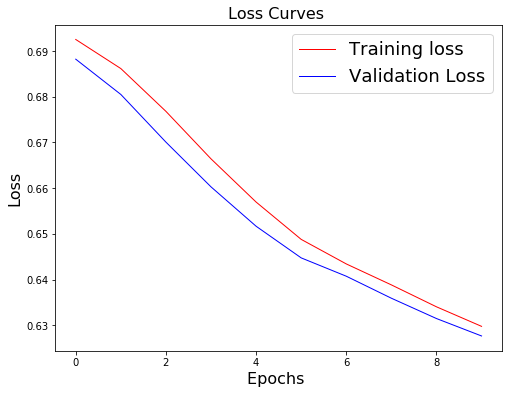

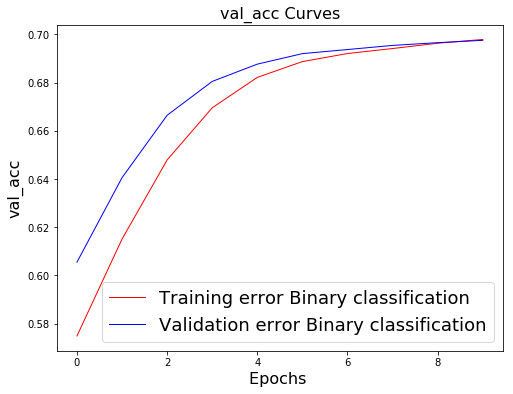

In [4]:
import p7_util

list_model_acc_value = p7_util.p7_plot_cnn_history(model, None, None, history=history, legend='Binary classification')

177863/177863 [==============================] - 10s 54us/step
[0, 1]

Confusion matrix for all classes : 

[[123718    705]
 [ 53091    349]]

Normalized confusion matrix
[[0.99433385 0.00566615]
 [0.99346931 0.00653069]]

TP rate = [0.         0.00653069 1.        ]
FP rate = [0.         0.00566615 1.        ]


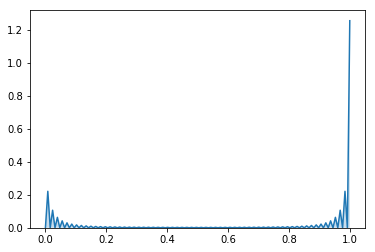

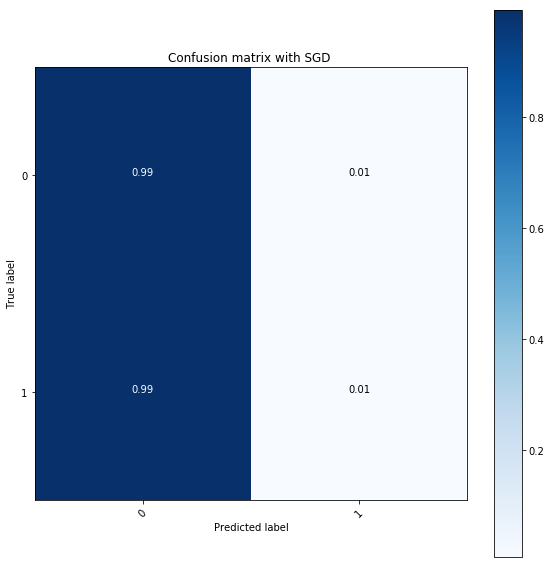

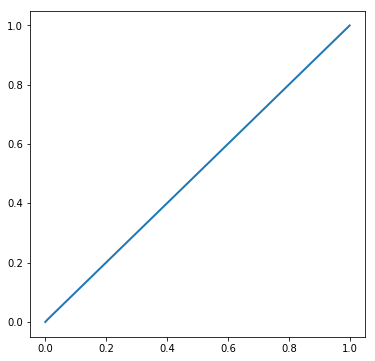

In [23]:
import p9_util
y_= p9_util.display_class_performance(model, X_test_reshape, y_test_label_bin, is_binary=True, y_pred=None)

    FP rate and TP rate are equal. Such model has a poor capacity of prediction.

#### <font color='blus'>2.1.3.2 Adagrad optimizer</font>

In [25]:
import p9_util

rnnCellType = 'GRU'
batch_size = X_train.shape[0]//10
model = p9_util.keras_rnn_build(rnnCellType, cell_units, max_length, isWordEmbedding=False\
                   , nbClasses=nb_classes, rnn_layers=rnn_layers, optimizer_name='Adagrad',is_batch_normalized=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 1, 16)             5616      
_________________________________________________________________
batch_normalization_1 (Batch (None, 1, 16)             64        
_________________________________________________________________
gru_2 (GRU)                  (None, 16)                1584      
_________________________________________________________________
batch_normalization_2 (Batch (None, 16)                64        
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 34        
Total params: 7,362
Trainable params: 7,298
Non-trainable params: 64
_________________________________________________________________
None


In [26]:
history = model.fit(X_train_reshape, y_train_label_bin, batch_size =batch_size, nb_epoch = 10
                    ,validation_data=(X_test_reshape,y_test_label_bin),  verbose = 1)

Train on 361241 samples, validate on 177863 samples
Epoch 1/10
361241/361241 [==============================] - 5s 13us/step - loss: 1.0668 - acc: 0.5424 - val_loss: 0.9460 - val_acc: 0.6070
Epoch 2/10
361241/361241 [==============================] - 1s 3us/step - loss: 0.9799 - acc: 0.5431 - val_loss: 0.9399 - val_acc: 0.5812
Epoch 3/10
361241/361241 [==============================] - 1s 3us/step - loss: 0.9339 - acc: 0.5462 - val_loss: 0.9086 - val_acc: 0.5805
Epoch 4/10
361241/361241 [==============================] - 1s 3us/step - loss: 0.9026 - acc: 0.5481 - val_loss: 0.8961 - val_acc: 0.5733
Epoch 5/10
361241/361241 [==============================] - 1s 3us/step - loss: 0.8774 - acc: 0.5513 - val_loss: 0.8656 - val_acc: 0.5823
Epoch 6/10
361241/361241 [==============================] - 1s 3us/step - loss: 0.8570 - acc: 0.5552 - val_loss: 0.8410 - val_acc: 0.5910
Epoch 7/10
361241/361241 [==============================] - 1s 3us/step - loss: 0.8400 - acc: 0.5587 - val_loss: 0.8130

#### <font color=blus>Computation of classifications performances</font>

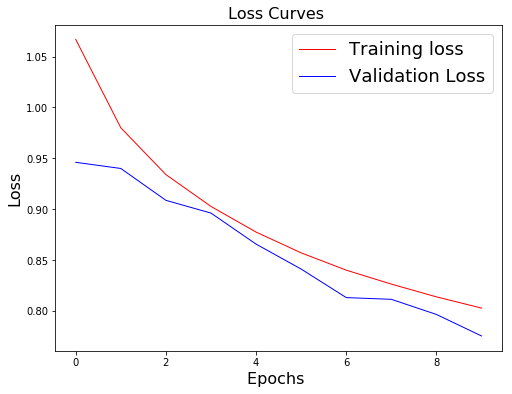

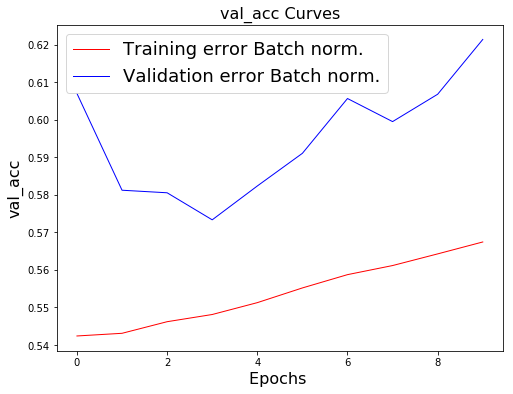

In [27]:
import p7_util

list_model_acc_value = p7_util.p7_plot_cnn_history(model, None, None, history=history, legend='Batch norm.')

177863/177863 [==============================] - 6s 33us/step
[0, 1]

Confusion matrix for all classes : 

[[110335  67030]
 [   318    180]]

Normalized confusion matrix
[[0.62207876 0.37792124]
 [0.63855422 0.36144578]]

TP rate = [0.         0.36144578 1.        ]
FP rate = [0.         0.37792124 1.        ]


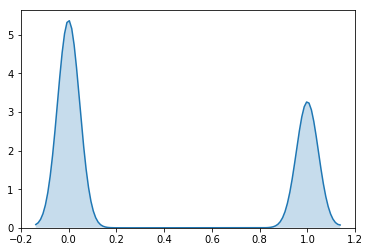

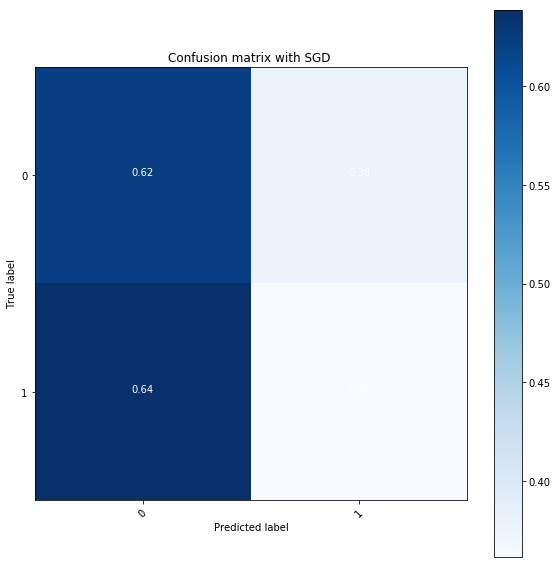

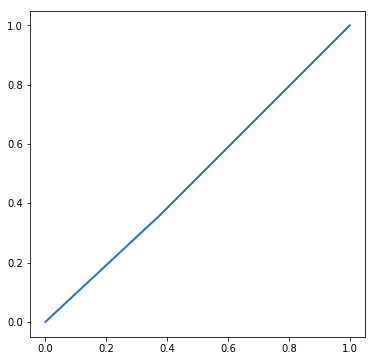

In [28]:
import p9_util
y_= p9_util.display_class_performance(model, X_test_reshape, y_test_label_bin, is_binary=True, y_pred=None)

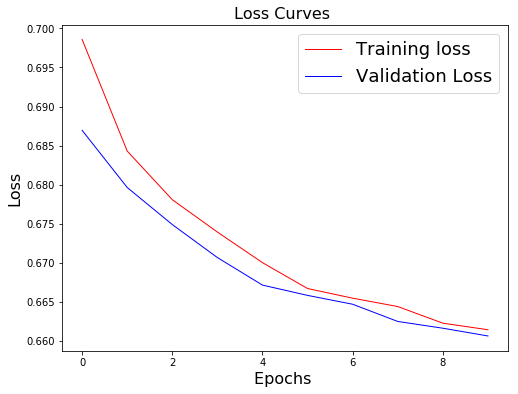

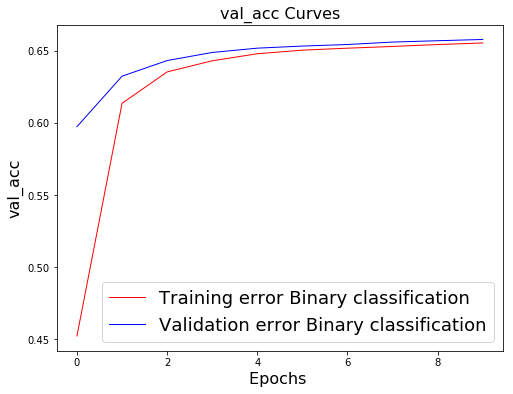

In [29]:
import p7_util

list_model_acc_value = p7_util.p7_plot_cnn_history(model, None, None, history=history, legend='Binary classification')

177863/177863 [==============================] - 7s 42us/step
[0, 1]

Confusion matrix for all classes : 

[[110147  14276]
 [ 46591   6849]]

Normalized confusion matrix
[[0.88526237 0.11473763]
 [0.87183757 0.12816243]]

TP rate = [0.         0.12816243 1.        ]
FP rate = [0.         0.11473763 1.        ]


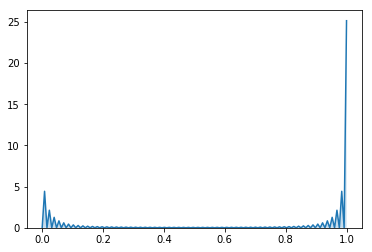

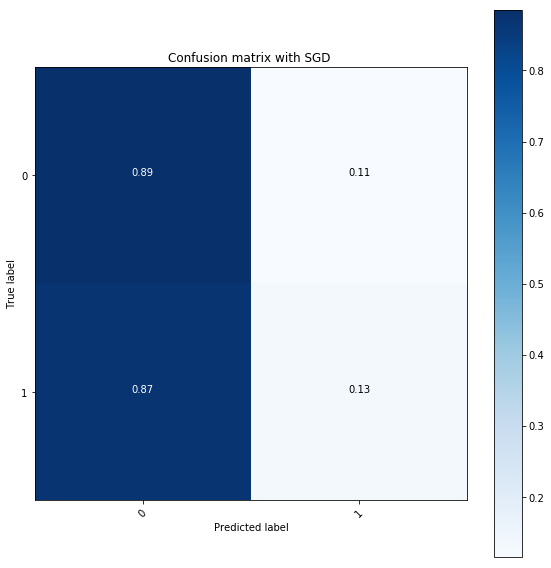

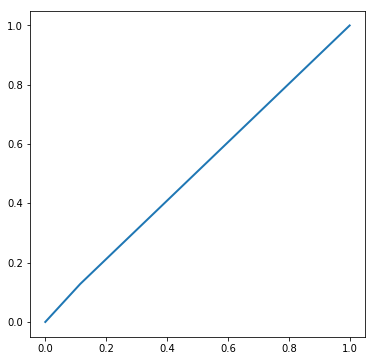

In [30]:
import p9_util
y_= p9_util.display_class_performance(model, X_test_reshape, y_test_label_bin, is_binary=True, y_pred=None)

    FP and TP rates are lightly degraded with Adagrad, while TN and FN rates are lightly improved, 
    compared to SGD. 

### <font color=blus>2.1.4 Classes balancing</font>

    Statiscics below show how classes are unbalanced.
    
    The goal of balancing classes is to balance contributions to loss reduction of all classes.

In [29]:
from collections import Counter
counter_y_train_label_bin = Counter(y_train_label_vect_bin)
counter_y_test_label_bin  = Counter(y_test_label_vect_bin)

print(counter_y_train_label_bin, counter_y_train_label_bin[0]+counter_y_train_label_bin[1])
print(counter_y_test_label_bin, counter_y_test_label_bin[0]+counter_y_test_label_bin[1])

Counter({0: 253411, 1: 107830}) 361241
Counter({0: 177365, 1: 498}) 177863


    The sampling strategy consists in having same number of observations for both classes 0 (majority class) 
    and 1 (minority class).

In [30]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import TomekLinks

minority_count = counter_y_train_label_bin[1]

sampling_strategy = {0: minority_count, 1: minority_count}
rus = RandomUnderSampler(sampling_strategy=sampling_strategy)
X_train_sampling, y_train_label_vect_bin_sampling = rus.fit_resample(X_train, y_train_label_vect_bin)
X_train_sampling.shape, y_train_label_vect_bin_sampling.shape

((215660, 100), (215660,))

In [31]:
print('Resampled dataset shape = {}'.format(Counter(y_train_label_vect_bin_sampling)))
print("X_train shape={} y_train.shape= {}".format(X_train_sampling.shape,y_train_label_vect_bin_sampling.shape))

Resampled dataset shape = Counter({0: 107830, 1: 107830})
X_train shape=(215660, 100) y_train.shape= (215660,)


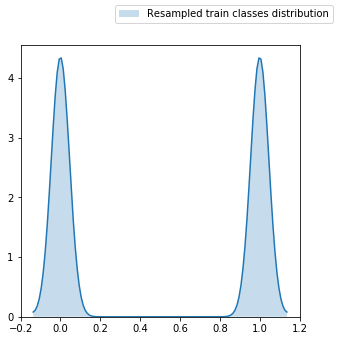

In [32]:
fig = plt.figure(figsize=(5,5))
_=sns.kdeplot(y_train_label_vect_bin_sampling, shade=True)
#_=sns.kdeplot(y_test_label_bin, shade=True)
fig.legend(labels=['Resampled train classes distribution'])
plt.show()

    Now, all classes are equally distributed into train target.

#### <font color='blus'>Dataset is reshaped in order to feed RNN</font>

For feeding RNN network, `y_train_label_bin_split` and `y_test_label_bin` are converted into matrix where 
number of columns is the number of classes.

Sampled vector, `y_train_label_vect_bin_sampling`, is converted into a matrix with 2 columns.

For test target values, `y_test_label_bin` is already converted as a matrix

In [39]:
import p9_util

X_train_reshape = p9_util.keras_rnn_reshape(X_train_sampling)
X_test_reshape = p9_util.keras_rnn_reshape(X_test)

print(y_test_label_bin.shape)

nb_classes, y_train_label_bin_sampling = p9_util.y_cont_2_label(y_train_label_vect_bin_sampling, decimal_count=0)
print(y_train_label_bin_sampling.shape)
print(nb_classes)

(215660, 1, 100)
(177863, 1, 100)
(177863, 2)
(215660, 2)
2


#### <font color='blus'>Appying RNN model to binary classification with balanced sampling</font>

In [40]:
import p9_util

rnnCellType = 'GRU'
batch_size = X_train.shape[0]//10
rnn_layers=2
cell_units=32
model = p9_util.keras_rnn_build(rnnCellType, cell_units, max_length, isWordEmbedding=False\
                   , nbClasses=nb_classes, rnn_layers=rnn_layers, optimizer_name='Adagrad',
                   lr=5.e-2, is_batch_normalized=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_6 (GRU)                  (None, 1, 32)             12768     
_________________________________________________________________
batch_normalization_6 (Batch (None, 1, 32)             128       
_________________________________________________________________
gru_7 (GRU)                  (None, 1, 32)             6240      
_________________________________________________________________
batch_normalization_7 (Batch (None, 1, 32)             128       
_________________________________________________________________
gru_8 (GRU)                  (None, 32)                6240      
_________________________________________________________________
batch_normalization_8 (Batch (None, 32)                128       
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 66        
Total para

In [41]:
history = model.fit(X_train_reshape, y_train_label_bin_sampling, batch_size =batch_size, nb_epoch = 30
                    ,validation_data=(X_test_reshape,y_test_label_bin),  verbose = 1, shuffle=True)

Train on 215660 samples, validate on 177863 samples
Epoch 1/30
215660/215660 [==============================] - 5s 24us/step - loss: 0.9310 - acc: 0.4881 - val_loss: 0.7801 - val_acc: 0.6842
Epoch 2/30
215660/215660 [==============================] - 1s 6us/step - loss: 0.8376 - acc: 0.5141 - val_loss: 0.7572 - val_acc: 0.6863
Epoch 3/30
215660/215660 [==============================] - 1s 6us/step - loss: 0.8020 - acc: 0.5187 - val_loss: 0.7406 - val_acc: 0.6868
Epoch 4/30
215660/215660 [==============================] - 1s 6us/step - loss: 0.7815 - acc: 0.5216 - val_loss: 0.7299 - val_acc: 0.6864
Epoch 5/30
215660/215660 [==============================] - 1s 6us/step - loss: 0.7681 - acc: 0.5234 - val_loss: 0.7240 - val_acc: 0.6828
Epoch 6/30
215660/215660 [==============================] - 1s 6us/step - loss: 0.7584 - acc: 0.5241 - val_loss: 0.7196 - val_acc: 0.6794
Epoch 7/30
215660/215660 [==============================] - 1s 6us/step - loss: 0.7512 - acc: 0.5239 - val_loss: 0.7169

##### <font color=blus>Computation of classifications performances</font>

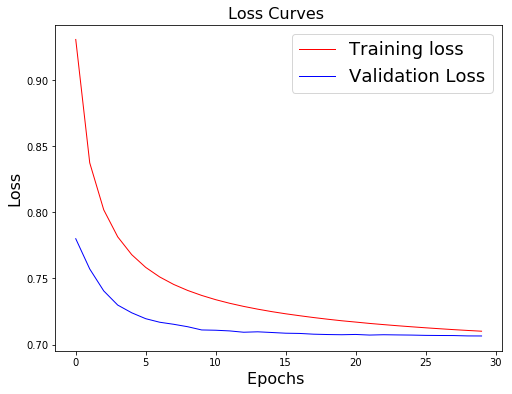

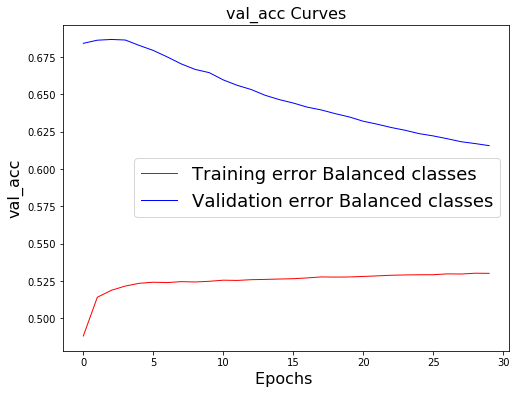

In [42]:
import p7_util

list_model_acc_value = p7_util.p7_plot_cnn_history(model, None, None, history=history, legend='Balanced classes')

177863/177863 [==============================] - 12s 67us/step
[0, 1]

Confusion matrix for all classes : 

[[109316  68049]
 [   314    184]]

Normalized confusion matrix
[[0.61633355 0.38366645]
 [0.63052209 0.36947791]]

TP rate = [0.         0.36947791 1.        ]
FP rate = [0.         0.38366645 1.        ]


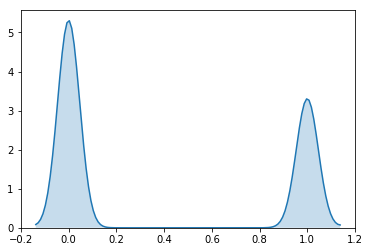

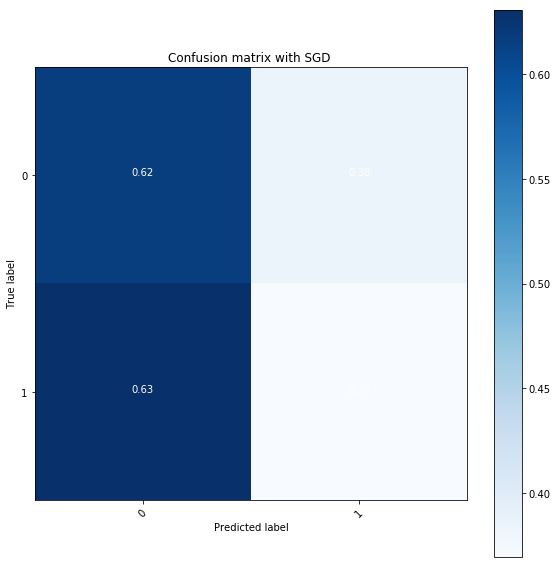

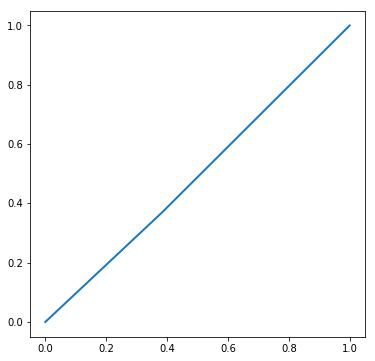

In [43]:
import p9_util
y_= p9_util.display_class_performance(model, X_test_reshape, y_test_label_bin, is_binary=True, y_pred=None)

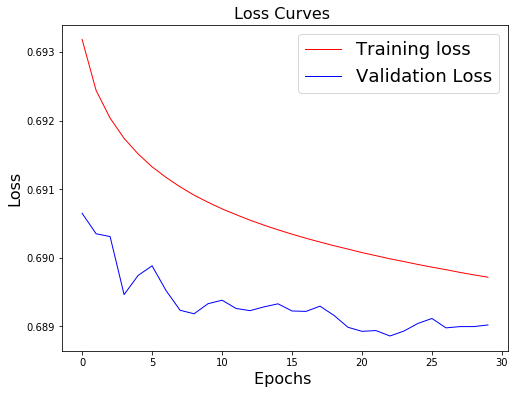

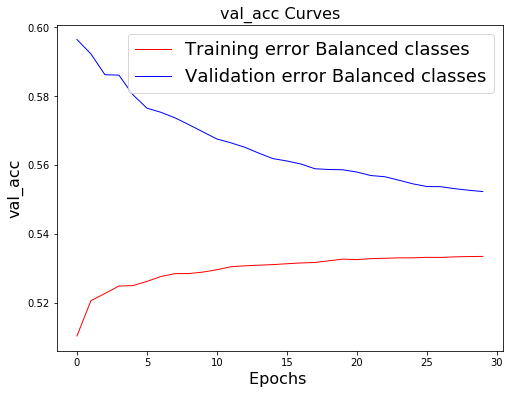

In [102]:
import p7_util

list_model_acc_value = p7_util.p7_plot_cnn_history(model, None, None, history=history, legend='Balanced classes')

177863/177863 [==============================] - 14s 80us/step
[0, 1]

Confusion matrix for all classes : 

[[72769 51654]
 [27985 25455]]

Normalized confusion matrix
[[0.58485168 0.41514832]
 [0.52367141 0.47632859]]

TP rate = [0.         0.47632859 1.        ]
FP rate = [0.         0.41514832 1.        ]


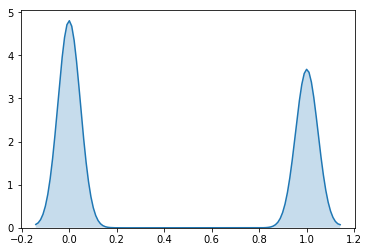

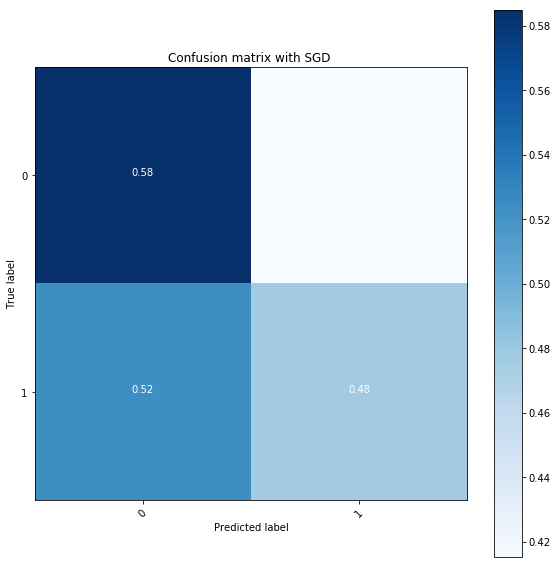

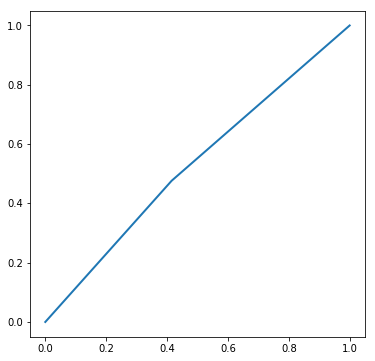

In [103]:
import p9_util
y_= p9_util.display_class_performance(model, X_test_reshape, y_test_label_bin, is_binary=True, y_pred=None)

    Effect of classes balancing over classification is strong.
    Minority classes do contribute better to loss function decrease then they did in the inbalanced 
    classes case.

    Nevertheless, even if model complexity increase with number of units per cell and/or number of 
    stacked layers, global performance remain very poor, slightly better than a random predictor, conidering 
    TP versus FP curve.

### <font color='blus'>2.1.5. CSL : Cost Sensitive Learning</font>

    Clases are assigne with weights, depending class occurencies. 
    Minority classes are more heavy weights then majority classes.

In [129]:
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced', np.unique(y_train_label_vect_bin), y_train_label_vect_bin)

print("\nClasses weights = {}".format(class_weights))


Classes weights = [0.71275714 1.67504869]


In [130]:
y_train_label_bin.shape, y_test_label_bin.shape, y_train_label_vect_bin.shape, y_test_label_vect_bin.shape

((361241, 2), (177863, 2), (361241,), (177863,))

#### <font color='blus'>Dataset is reshaped in order to feed RNN</font>

For feeding RNN network, `y_train_label_bin` and `y_test_label_bin` are converted into matrix where 
number of columns is the number of classes.

For test target values, `y_test_label_bin` is already converted as a matrix

In [131]:
import p9_util

X_train_reshape = p9_util.keras_rnn_reshape(X_train)
X_test_reshape = p9_util.keras_rnn_reshape(X_test)

print(y_train_label_bin.shape)
print(y_test_label_bin.shape)

#nb_classes, y_train_label_bin = p9_util.y_reg_2_label(y_train_label_vect_bin, decimal_count=0)
#print(y_train_label_bin_sampling.shape)

(361241, 1, 100)
(177863, 1, 100)
(361241, 2)
(177863, 2)


#### <font color=blus>2.1.4.1 Building GRU model with 1 layer </font>

In [132]:
lstm_out = 1
cell_units = 16*2
rnn_layers = 1

In [138]:
import p9_util

rnnCellType = 'GRU'
batch_size = X_train.shape[0]//10
model = p9_util.keras_rnn_build(rnnCellType, cell_units, max_length, isWordEmbedding=False\
                   , nbClasses=nb_classes, rnn_layers=rnn_layers, is_batch_normalized=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_13 (GRU)                 (None, 1, 32)             12768     
_________________________________________________________________
batch_normalization_11 (Batc (None, 1, 32)             128       
_________________________________________________________________
gru_14 (GRU)                 (None, 32)                6240      
_________________________________________________________________
batch_normalization_12 (Batc (None, 32)                128       
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 66        
Total params: 19,330
Trainable params: 19,202
Non-trainable params: 128
_________________________________________________________________
None


In [139]:
history = model.fit(X_train_reshape, y_train_label_bin, batch_size =batch_size, nb_epoch = 30
                    ,validation_data=(X_test_reshape,y_test_label_bin),  verbose = 1, 
                    class_weight=class_weights)

Train on 361241 samples, validate on 177863 samples
Epoch 1/30
361241/361241 [==============================] - 6s 15us/step - loss: 0.8589 - acc: 0.4386 - val_loss: 0.8623 - val_acc: 0.3912
Epoch 2/30
361241/361241 [==============================] - 2s 4us/step - loss: 0.8164 - acc: 0.4727 - val_loss: 0.7619 - val_acc: 0.5922
Epoch 3/30
361241/361241 [==============================] - 2s 4us/step - loss: 0.7727 - acc: 0.5663 - val_loss: 0.6935 - val_acc: 0.6913
Epoch 4/30
361241/361241 [==============================] - 2s 5us/step - loss: 0.7394 - acc: 0.5978 - val_loss: 0.6713 - val_acc: 0.7147
Epoch 5/30
361241/361241 [==============================] - 2s 5us/step - loss: 0.7152 - acc: 0.6159 - val_loss: 0.6234 - val_acc: 0.7635
Epoch 6/30
361241/361241 [==============================] - 2s 5us/step - loss: 0.6973 - acc: 0.6289 - val_loss: 0.5882 - val_acc: 0.7961
Epoch 7/30
361241/361241 [==============================] - 2s 6us/step - loss: 0.6839 - acc: 0.6393 - val_loss: 0.5509

#### <font color=blus>Computation of classifications performances</font>

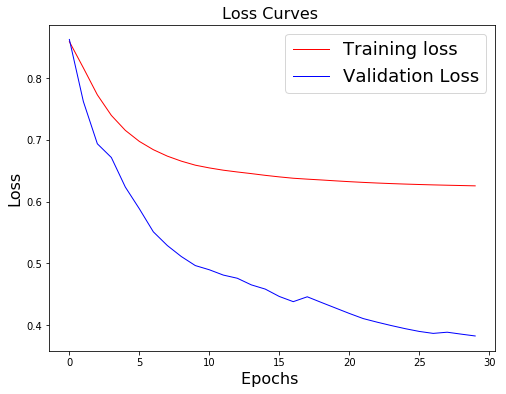

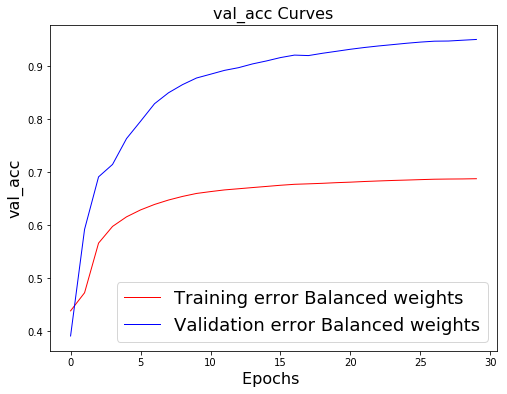

In [140]:
import p7_util

list_model_acc_value = p7_util.p7_plot_cnn_history(model, None, None, history=history, legend='Balanced weights')

177863/177863 [==============================] - 9s 50us/step
[0, 1]

Confusion matrix for all classes : 

[[169024   8341]
 [   482     16]]

Normalized confusion matrix
[[0.95297268 0.04702732]
 [0.96787149 0.03212851]]

TP rate = [0.         0.03212851 1.        ]
FP rate = [0.         0.04702732 1.        ]


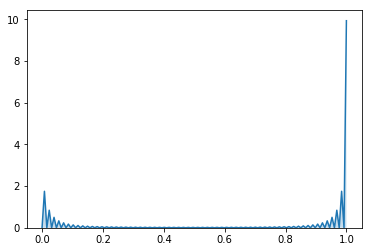

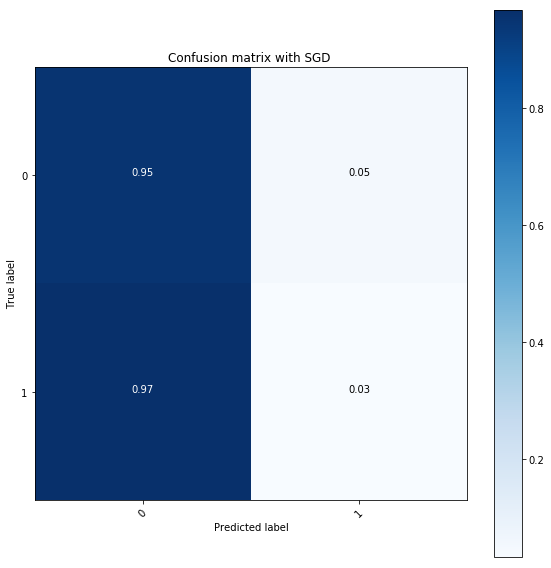

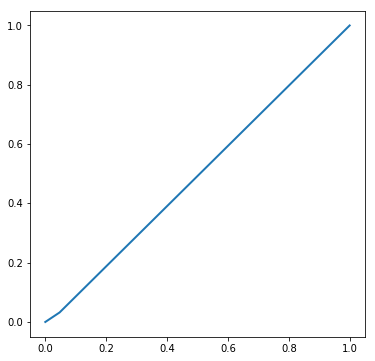

In [141]:
import p9_util
y_= p9_util.display_class_performance(model, X_test_reshape, y_test_label_bin, is_binary=True, y_pred=None)

#### <font color=blus> 2.1.4.2 Building GRU model with 2 layers </font>

In [142]:
rnn_layers=2

In [143]:
import p9_util

rnnCellType = 'GRU'
batch_size = X_train.shape[0]//10
model = p9_util.keras_rnn_build(rnnCellType, cell_units, max_length, isWordEmbedding=False\
                   , nbClasses=nb_classes, rnn_layers=rnn_layers, is_batch_normalized=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_15 (GRU)                 (None, 1, 32)             12768     
_________________________________________________________________
batch_normalization_13 (Batc (None, 1, 32)             128       
_________________________________________________________________
gru_16 (GRU)                 (None, 1, 32)             6240      
_________________________________________________________________
batch_normalization_14 (Batc (None, 1, 32)             128       
_________________________________________________________________
gru_17 (GRU)                 (None, 32)                6240      
_________________________________________________________________
batch_normalization_15 (Batc (None, 32)                128       
_________________________________________________________________
dense_7 (Dense)              (None, 2)                 66        
Total para

In [144]:
history = model.fit(X_train_reshape, y_train_label_bin, batch_size =batch_size, nb_epoch = 30
                    ,validation_data=(X_test_reshape,y_test_label_bin),  verbose = 1, class_weight=class_weights)

Train on 361241 samples, validate on 177863 samples
Epoch 1/30
361241/361241 [==============================] - 7s 18us/step - loss: 0.9075 - acc: 0.4674 - val_loss: 0.8473 - val_acc: 0.5649
Epoch 2/30
361241/361241 [==============================] - 2s 6us/step - loss: 0.8352 - acc: 0.5398 - val_loss: 0.7567 - val_acc: 0.6274
Epoch 3/30
361241/361241 [==============================] - 2s 6us/step - loss: 0.7753 - acc: 0.5711 - val_loss: 0.5948 - val_acc: 0.7445
Epoch 4/30
361241/361241 [==============================] - 2s 6us/step - loss: 0.7343 - acc: 0.5967 - val_loss: 0.5779 - val_acc: 0.7610
Epoch 5/30
361241/361241 [==============================] - 2s 6us/step - loss: 0.7093 - acc: 0.6148 - val_loss: 0.5635 - val_acc: 0.7790
Epoch 6/30
361241/361241 [==============================] - 3s 7us/step - loss: 0.6924 - acc: 0.6283 - val_loss: 0.5365 - val_acc: 0.8034
Epoch 7/30
361241/361241 [==============================] - 2s 6us/step - loss: 0.6809 - acc: 0.6384 - val_loss: 0.5308

#### <font color=blus>Computation of classifications performances</font>

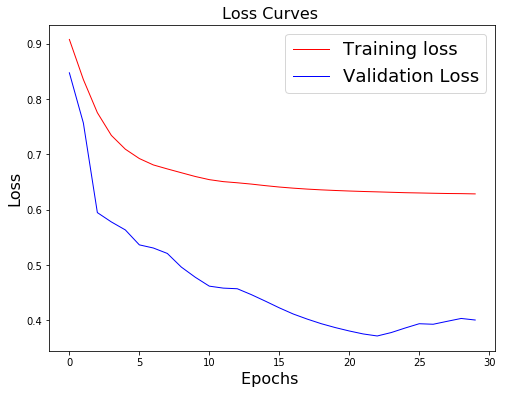

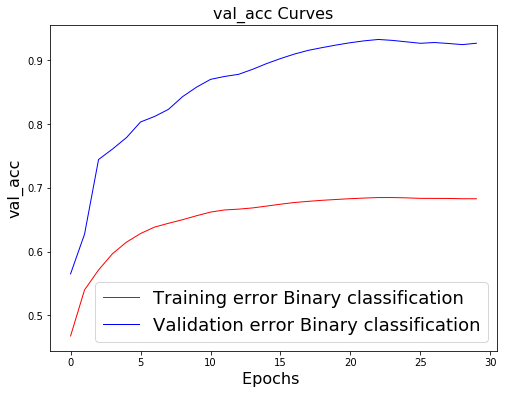

In [145]:
import p7_util

list_model_acc_value = p7_util.p7_plot_cnn_history(model, None, None, history=history, legend='Binary classification')

177863/177863 [==============================] - 14s 81us/step
[0, 1]

Confusion matrix for all classes : 

[[124423      0]
 [ 53440      0]]

Normalized confusion matrix
[[1. 0.]
 [1. 0.]]

TP rate = [0. 1.]
FP rate = [0. 1.]


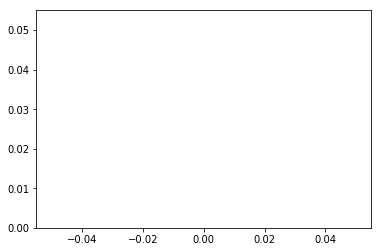

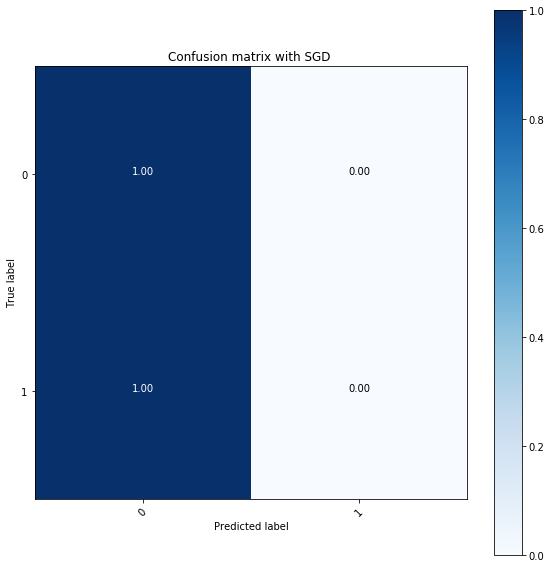

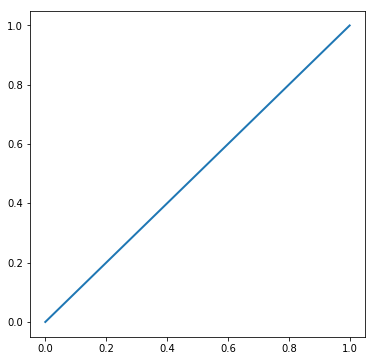

In [140]:
import p9_util
y_= p9_util.display_class_performance(model, X_test_reshape, y_test_label_bin, is_binary=True, y_pred=None)

In [ ]:
import p9_util
toxicity_threshold = 0.5
y_train_label = np.where(y_train <= toxicity_threshold, 0, 1)
y_test_label  = np.where(y_test  <= toxicity_threshold, 0, 1)

nb_classes, y_train_label = p9_util.y_reg_2_label(y_train_label)
_, y_test_label = p9_util.y_reg_2_label(y_test_label)


nb_classes = y_train_label.shape[1]
print("\nNumber of classes issued from one hot encoding= {}".format(nb_classes))

In [ ]:
print(cell_units, max_length,nb_classes)

In [ ]:
import p9_util

rnnCellType = 'GRU'

model = p9_util.keras_rnn_build(rnnCellType, cell_units, max_length, isWordEmbedding=False\
                   , nbClasses=nb_classes)

In [ ]:
history = model.fit(X_train_reshape, y_train_label, batch_size =batch_size, nb_epoch = 10
                    ,validation_data=(X_test_reshape,y_test_label),  verbose = 1)

#### <font color=blus>Computation of classifications performances</font>

In [ ]:
import p7_util

list_model_acc_value = p7_util.p7_plot_cnn_history(model, None, None, history=history, legend='Binary classification')

    It can be seen that, even if cost function may continue to decrease, then
    accuracy will not improve.
    This is due to influence of a great number of observations that are toxicity free, considering 
    others observations.

    Toxicity predictions classes are firstly computed from test dataset issued from texts to be tested.
    Target test vector, a [Nx11] matrix, is transformed into a vector of N rows.
    For achieving this, function 
`p9_util.get_label_from_row()` 

    is used for any row from matrix.
    This allows to compute confusion matrix then plot it.

In [ ]:
import p9_util
y_= p9_util.display_class_performance(model, X_test_reshape, y_test_label, is_binary=True, y_pred=y_)

#### <font color='blus'> Use of Adagrad optimizer for binary classification</font>

In [146]:
import p9_util

rnnCellType = 'GRU'

model = p9_util.keras_rnn_build(rnnCellType, cell_units, max_length, isWordEmbedding=False\
                   , nbClasses=nb_classes, optimizer_name='Adagrad', is_batch_normalized=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_18 (GRU)                 (None, 1, 32)             12768     
_________________________________________________________________
batch_normalization_16 (Batc (None, 1, 32)             128       
_________________________________________________________________
gru_19 (GRU)                 (None, 32)                6240      
_________________________________________________________________
batch_normalization_17 (Batc (None, 32)                128       
_________________________________________________________________
dense_8 (Dense)              (None, 2)                 66        
Total params: 19,330
Trainable params: 19,202
Non-trainable params: 128
_________________________________________________________________
None


In [148]:
history = model.fit(X_train_reshape, y_train_label_bin, batch_size =batch_size, nb_epoch = 30
                    ,validation_data=(X_test_reshape,y_test_label_bin),  verbose = 1, class_weight=class_weights)

Train on 361241 samples, validate on 177863 samples
Epoch 1/30
361241/361241 [==============================] - 5s 14us/step - loss: 0.9226 - acc: 0.4547 - val_loss: 0.7793 - val_acc: 0.5986
Epoch 2/30
361241/361241 [==============================] - 2s 4us/step - loss: 0.8253 - acc: 0.5150 - val_loss: 0.7287 - val_acc: 0.6466
Epoch 3/30
361241/361241 [==============================] - 2s 4us/step - loss: 0.7853 - acc: 0.5406 - val_loss: 0.7093 - val_acc: 0.6594
Epoch 4/30
361241/361241 [==============================] - 2s 4us/step - loss: 0.7610 - acc: 0.5552 - val_loss: 0.6927 - val_acc: 0.6738
Epoch 5/30
361241/361241 [==============================] - 2s 5us/step - loss: 0.7443 - acc: 0.5665 - val_loss: 0.6700 - val_acc: 0.7006
Epoch 6/30
361241/361241 [==============================] - 2s 6us/step - loss: 0.7331 - acc: 0.5735 - val_loss: 0.6642 - val_acc: 0.7062
Epoch 7/30
361241/361241 [==============================] - 2s 5us/step - loss: 0.7246 - acc: 0.5792 - val_loss: 0.6643

##### <font color=blus>Computation of binary classifications performances</font>

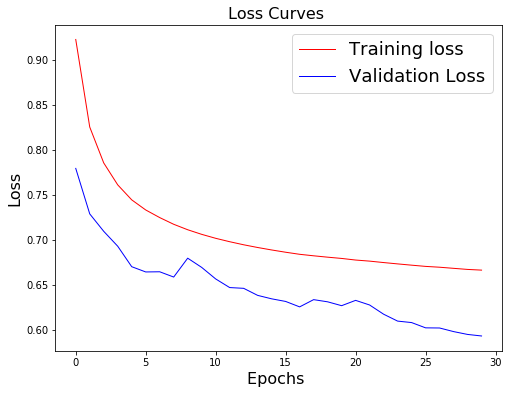

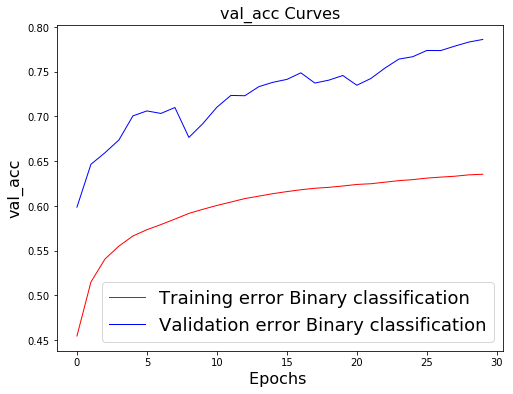

In [149]:
import p7_util

list_model_acc_value = p7_util.p7_plot_cnn_history(model, None, None, history=history, legend='Binary classification')

    Here under, distributions of computed predictions are calculated.

177863/177863 [==============================] - 10s 58us/step
[0, 1]

Confusion matrix for all classes : 

[[139710  37655]
 [   397    101]]

Normalized confusion matrix
[[0.78769769 0.21230231]
 [0.79718876 0.20281124]]

TP rate = [0.         0.20281124 1.        ]
FP rate = [0.         0.21230231 1.        ]


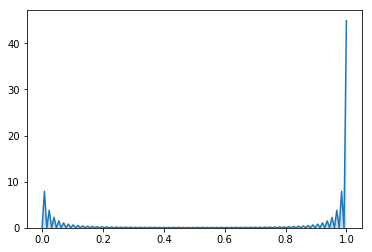

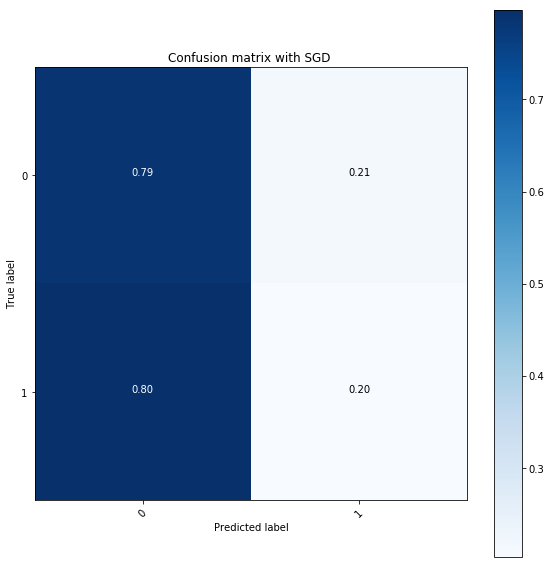

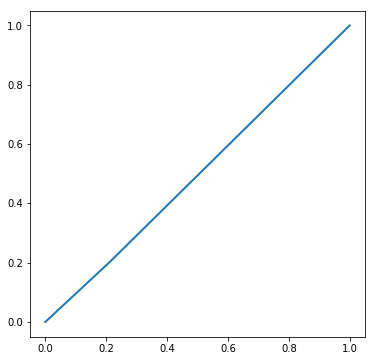

In [150]:
import p9_util
y_= p9_util.display_class_performance(model, X_test_reshape, y_test_label, is_binary=True, y_pred=None)

#### <font color='blus'> Increase the number of dense layers into RNN</font>

In [162]:
import p9_util

rnnCellType = 'GRU'
cell_units=16
model = p9_util.keras_rnn_build(rnnCellType, cell_units, max_length, isWordEmbedding=False,\
                   nbClasses=nb_classes, optimizer_name='Adagrad',\
                    is_batch_normalized=True, dense_layer_count=1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_28 (GRU)                 (None, 1, 16)             5616      
_________________________________________________________________
batch_normalization_31 (Batc (None, 1, 16)             64        
_________________________________________________________________
gru_29 (GRU)                 (None, 16)                1584      
_________________________________________________________________
batch_normalization_32 (Batc (None, 16)                64        
_________________________________________________________________
dense_18 (Dense)             (None, 2)                 34        
Total params: 7,362
Trainable params: 7,298
Non-trainable params: 64
_________________________________________________________________
None


In [166]:
class_weights[1] = class_weights[1]*4
class_weights

array([ 0.71275714, 26.800779  ])

In [167]:
history = model.fit(X_train_reshape, y_train_label_bin, batch_size =batch_size, nb_epoch = 30
                    ,validation_data=(X_test_reshape,y_test_label_bin),  verbose = 1, 
                    class_weight=class_weights)

Train on 361241 samples, validate on 177863 samples
Epoch 1/30
361241/361241 [==============================] - 1s 3us/step - loss: 0.6906 - acc: 0.6193 - val_loss: 0.6476 - val_acc: 0.7404
Epoch 2/30
361241/361241 [==============================] - 1s 3us/step - loss: 0.6890 - acc: 0.6207 - val_loss: 0.6427 - val_acc: 0.7467
Epoch 3/30
361241/361241 [==============================] - 1s 3us/step - loss: 0.6876 - acc: 0.6219 - val_loss: 0.6421 - val_acc: 0.7475
Epoch 4/30
361241/361241 [==============================] - 1s 3us/step - loss: 0.6862 - acc: 0.6231 - val_loss: 0.6371 - val_acc: 0.7531
Epoch 5/30
361241/361241 [==============================] - 1s 3us/step - loss: 0.6852 - acc: 0.6241 - val_loss: 0.6328 - val_acc: 0.7576
Epoch 6/30
361241/361241 [==============================] - 1s 4us/step - loss: 0.6842 - acc: 0.6249 - val_loss: 0.6316 - val_acc: 0.7590
Epoch 7/30
361241/361241 [==============================] - 1s 4us/step - loss: 0.6830 - acc: 0.6258 - val_loss: 0.6201 

##### <font color=blus>Computation of binary classifications performances</font>

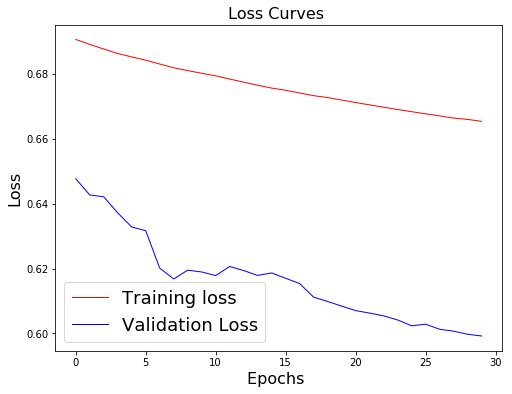

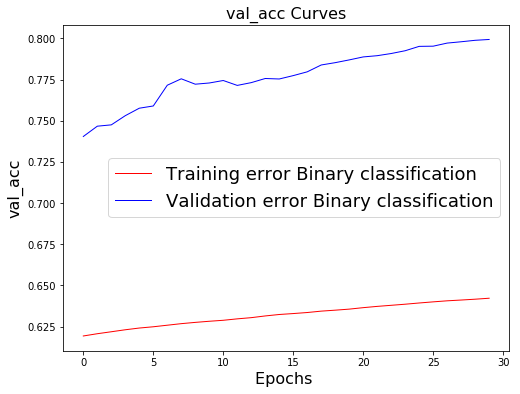

In [168]:
import p7_util

list_model_acc_value = p7_util.p7_plot_cnn_history(model, None, None, history=history, legend='Binary classification')

177863/177863 [==============================] - 9s 51us/step
[0, 1]

Confusion matrix for all classes : 

[[142091  35274]
 [   413     85]]

Normalized confusion matrix
[[0.80112198 0.19887802]
 [0.82931727 0.17068273]]

TP rate = [0.         0.17068273 1.        ]
FP rate = [0.         0.19887802 1.        ]


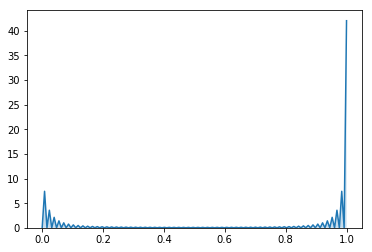

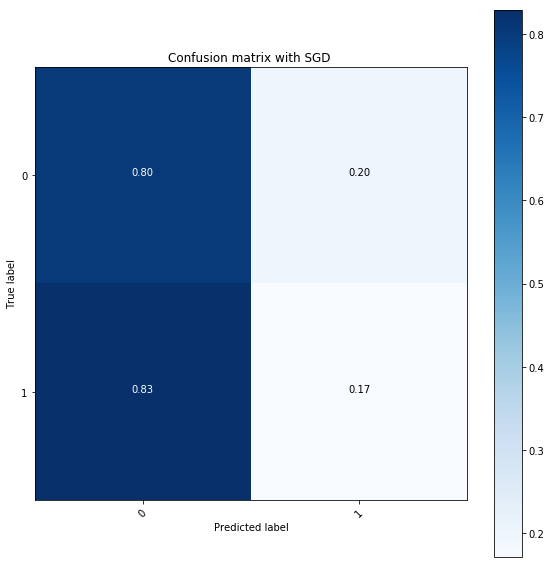

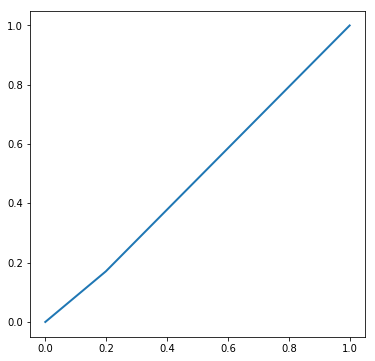

In [169]:
import p9_util
y_= p9_util.display_class_performance(model, X_test_reshape, y_test_label, is_binary=True, y_pred=None)